# Sudoku Example with PuLP

cuOpt is NVIDIA's GPU accelerated solver that delivers massive speedups for real-world LP, MIP, and VRP workloads.

cuOpt seemlessly integrates with modeling languages. You can drop cuOpt into existing models built with PuLP and AMPL, with minimal refactoring. Let's take a look at an example solving a simple MIP problem with cuOpt.

To run this in Google Colab, download the notebook and upload it to Google Colab. Make sure you are running this on a T4 GPU.

If you are running this in the cuOpt container, you are good to go!

This example is borrowed from PuLP. You can find it on their website __[here](https://coin-or.github.io/pulp/CaseStudies/a_sudoku_problem.html)__


## 1. Install Dependencies

To make sure we are good to go, let's install PuLP and cuOpt.

__[PuLP](https://coin-or.github.io/pulp/)__ is a popular linear and mixed integer programming modeler written in Python.


If you are running this notebook in Google Colab, or elsewhere outside the container where cuOpt is not yet installed, uncomment the pip install command to install cuOpt.

In [ ]:
 !pip install pulp==3.2.0

In [ ]:
# # Enable this in case you are running this in google colab or such places where cuOpt is not yet installed

#!pip install --upgrade --extra-index-url=https://pypi.nvidia.com cuopt-cu12

## 2. Problem Setup

In this problem, we will use solve the following Sudoku problem

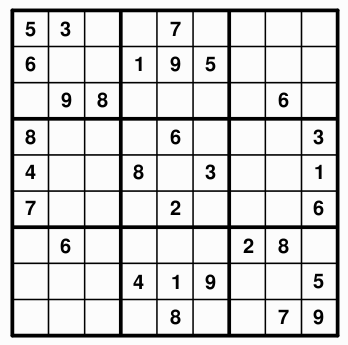

In [ ]:
"""
The Sudoku Problem Formulation for the PuLP Modeller

Authors: Antony Phillips, Dr Stuart Mitchell
edited by Nathan Sudermann-Merx
"""

# Import PuLP modeler functions
from pulp import *

# All rows, columns and values within a Sudoku take values from 1 to 9
VALS = ROWS = COLS = range(1, 10)

# The boxes list is created, with the row and column index of each square in each box
Boxes = [
    [(3 * i + k + 1, 3 * j + l + 1) for k in range(3) for l in range(3)]
    for i in range(3)
    for j in range(3)
]

# The prob variable is created to contain the problem data
prob = LpProblem("Sudoku Problem")

# The decision variables are created
choices = LpVariable.dicts("Choice", (VALS, ROWS, COLS), cat="Binary")

# We do not define an objective function since none is needed

# A constraint ensuring that only one value can be in each square is created
for r in ROWS:
    for c in COLS:
        prob += lpSum([choices[v][r][c] for v in VALS]) == 1

# The row, column and box constraints are added for each value
for v in VALS:
    for r in ROWS:
        prob += lpSum([choices[v][r][c] for c in COLS]) == 1

    for c in COLS:
        prob += lpSum([choices[v][r][c] for r in ROWS]) == 1

    for b in Boxes:
        prob += lpSum([choices[v][r][c] for (r, c) in b]) == 1

# The starting numbers are entered as constraints. 
# For example `(5, 1, 1)` means that there's a 5 in row=1,column=1. 
# Each number in our input problem is represented this way. All the indicies are 1-9, since that's the dimension of a Sudoku problem.
input_data = [
    (5, 1, 1),
    (6, 2, 1),
    (8, 4, 1),
    (4, 5, 1),
    (7, 6, 1),
    (3, 1, 2),
    (9, 3, 2),
    (6, 7, 2),
    (8, 3, 3),
    (1, 2, 4),
    (8, 5, 4),
    (4, 8, 4),
    (7, 1, 5),
    (9, 2, 5),
    (6, 4, 5),
    (2, 6, 5),
    (1, 8, 5),
    (8, 9, 5),
    (5, 2, 6),
    (3, 5, 6),
    (9, 8, 6),
    (2, 7, 7),
    (6, 3, 8),
    (8, 7, 8),
    (7, 9, 8),
    (3, 4, 9),
    (1, 5, 9),
    (6, 6, 9),
    (5, 8, 9),
]

for v, r, c in input_data:
    prob += choices[v][r][c] == 1


## 3. Problem Solution

PuLP calls on the cuOpt solver, which finds the missing values.  Let's take a look at the solution.

In [ ]:
# The problem is solved using cuOpt
prob.solve(CUOPT(msg=0))

# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

# Print the solution
for r in ROWS:
    if r in [1, 4, 7]:
        print("+-------+-------+-------+")
    row_output = ""
    for c in COLS:
        for v in VALS:
            if value(choices[v][r][c]) == 1:
                if c in [1, 4, 7]:
                    row_output += "| "
                row_output += str(v) + " "
                if c == 9:
                    row_output += "|"
    print(row_output)
print("+-------+-------+-------+")
